# CUDA Lab Assignment 6

## **Group members**

1. Areesha Asif
2. Abhishek S Pillai 

## Dataset Overview:
The Street View House Numbers (SVHN) Dataset. 
SVHN is a real-world image dataset, It can be seen as similar in flavor to MNIST, but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem. SVHN is obtained from house numbers in Google Street View images.
The dataset contain:
- 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.
- 73257 digits for training, 26032 digits for testing, and 531131 additional, somewhat less difficult samples, to use as extra training data

Reference: http://ufldl.stanford.edu/housenumbers/

# Dataset Loading

I used following link to understand how to load dataset in code:
https://pytorch.org/vision/stable/generated/torchvision.datasets.SVHN.html
and the major part of code is resused from session 6's code file.

In [1]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

In [2]:
from torch.utils.tensorboard import SummaryWriter

In [3]:
GAN_LOGS = os.path.join(os.getcwd(), "tboard_logs", "gan")
if not os.path.exists(GAN_LOGS):
    os.makedirs(GAN_LOGS)

In [4]:
shutil.rmtree(GAN_LOGS)
writer = SummaryWriter(GAN_LOGS)

In [5]:
if not os.path.exists("imgs"):
    os.makedirs("imgs")
shutil.rmtree("imgs/training")
if not os.path.exists("imgs/training"):
    os.makedirs("imgs/training")

In [6]:
# Downloading and Loading Dataset
SVHN_tf = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Pad(2),
        transforms.Normalize(mean=(0.5, ), std=(0.5, ))
    ])
train_dataset = datasets.SVHN(root='./data/train', split="train", transform=SVHN_tf, download=True)
test_dataset = datasets.SVHN(root='./data/test', split="test", transform=SVHN_tf, download=True)
#train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=mnist_tf, download=True)
#test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=mnist_tf)

Using downloaded and verified file: ./data/train/train_32x32.mat
Using downloaded and verified file: ./data/test/test_32x32.mat


In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True) 

In [8]:
# Iterate over the data loader
for images, labels in train_loader:
    labels = labels
print(labels)
print(labels.shape)

tensor([3, 1, 1, 5, 7, 0, 8, 0, 8, 6, 2, 5, 3, 8, 4, 0, 3, 9, 6, 2, 5, 0, 3, 5,
        9, 5, 6, 7, 7, 2, 1, 1, 4, 4, 2, 2, 2, 4, 2, 8, 5])
torch.Size([41])


In [9]:
imgs = next(iter(train_loader))[0]

In [10]:
print(imgs.shape)

torch.Size([64, 3, 32, 32])


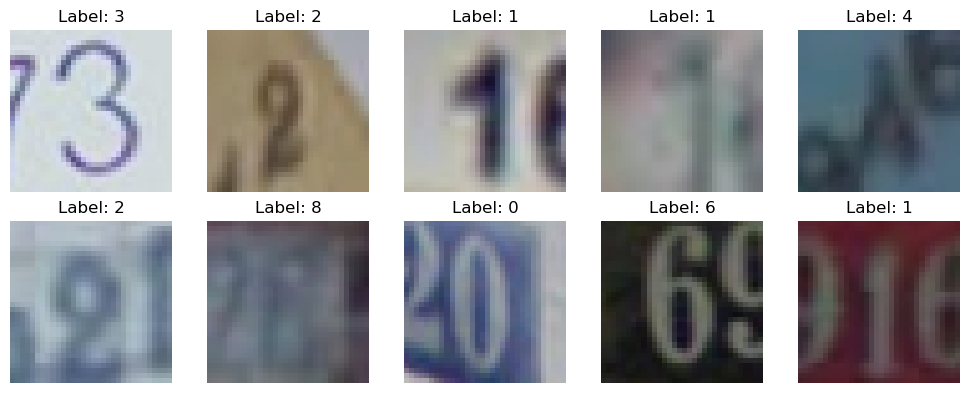

In [13]:
mean = 0.5
std = 0.5
n_rows = 2
n_cols = 5

dataiter = iter(train_loader)
images, labels = next(dataiter)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))

for i, ax in enumerate(axes.flatten()):
    img = images[i]
    img = np.transpose(img, (1, 2, 0))  
    img = (img * std) + mean  
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [14]:
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        self.embed.weight.data[:, :num_features].fill_(1.0)  # Initialize gamma
        self.embed.weight.data[:, num_features:].zero_()      # Initialize beta

    def forward(self, x, labels):
        out = self.bn(x)
        gamma, beta = self.embed(labels).chunk(2, 1)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        return out


I learned this approach from following link to condition model with labels. https://towardsdatascience.com/overview-of-gans-conditioning-methods-edeac018a7f3

In [15]:
class ConvBlock(nn.Module):
    """
    Simple convolutional block: Conv + Norm + Act + Dropout
    """
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, use_cond_bn=False, num_classes=10, add_norm=True, activation="ReLU", dropout=None):
        """ Module Initializer """
        super().__init__()
        assert activation in ["ReLU", "LeakyReLU", "Sigmoid", "Tanh", None]
        padding = kernel_size // 2
        
        block = []
        block.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride))
        if add_norm:
            if use_cond_bn:
                block.append(ConditionalBatchNorm2d(out_channels, num_classes))
            else:
                block.append(nn.BatchNorm2d(out_channels))
            
        if activation is not None:
            nonlinearity = getattr(nn, activation, nn.ReLU)()
            if isinstance(nonlinearity, nn.LeakyReLU):
                nonlinearity.negative_slope = 0.2
            block.append(nonlinearity)
            
        if dropout is not None:
            block.append(nn.Dropout(dropout))
            
        self.block =  nn.Sequential(*block)

    def forward(self, x, labels=None):
        for layer in self.block:
            if isinstance(layer, ConditionalBatchNorm2d):
                x = layer(x, labels)
            else:
                x = layer(x)
        return x


class ConvTransposeBlock(nn.Module):
    """
    Simple convolutional block: ConvTranspose + Norm + Act + Dropout
    """
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, use_cond_bn=False, num_classes=10, add_norm=True, activation="ReLU", dropout=None):
        """ Module Initializer """
        super().__init__()
        assert activation in ["ReLU", "LeakyReLU", "Tanh", None]
        padding = kernel_size // 2
        
        block = []
        block.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, stride=stride))
        if add_norm:
            if use_cond_bn:
                block.append(ConditionalBatchNorm2d(out_channels, num_classes))
            else:
                block.append(nn.BatchNorm2d(out_channels))
        if activation is not None:
            nonlinearity = getattr(nn, activation, nn.ReLU)()
            if isinstance(nonlinearity, nn.LeakyReLU):
                nonlinearity.negative_slope = 0.2
            block.append(nonlinearity)
        if dropout is not None:
            block.append(nn.Dropout(dropout))
            
        self.block =  nn.Sequential(*block)

    def forward(self, x, labels=None):
        for layer in self.block:
            if isinstance(layer, ConditionalBatchNorm2d):
                x = layer(x, labels)
            else:
                x = layer(x)
        return x

In [16]:
class Reshape(nn.Module):
    """ Reshaping a vector in a given shape """
    
    def __init__(self, shape):
        """ """
        super().__init__()
        self.shape = shape
        
    def forward(self, x):
        """ """
        B, N = x.shape
        x = x.view(B, N, 1, 1)
        y = x.repeat(1, 1, *self.shape)
        return y

In [17]:
class Generator(nn.Module):
    """
    A fully convolutional generator using ReLU activations. 
    Takes as input a latent vector and outputs a fake sample.
       (B, latent_dim, 1, 1)  --> (B, num_channels, 32, 32)
    """
    def __init__(self, latent_dim=128, num_channels=1, num_classes=10, base_channels=32):
        """ Model initializer """
        super().__init__()
        #self.label_emb = nn.Embedding(num_classes, latent_dim)

        layers = []
        for i in range(4):
            layers.append(
                ConvTransposeBlock(
                        in_channels=latent_dim if i == 0 else base_channels * 2 ** (3-i+1),
                        out_channels=base_channels * 2 ** (3-i),
                        kernel_size=4,
                        stride=1 if i == 0 else 2,
                        add_norm=True,
                        activation="ReLU",
                        use_cond_bn=True,
                    )
                )
        layers.append(
            ConvTransposeBlock(
                    in_channels=base_channels,
                    out_channels=num_channels,
                    kernel_size=4,
                    stride=2,
                    add_norm=False,
                    activation="Tanh",
                    use_cond_bn=True,
                )
            )
        
        self.model = nn.Sequential(*layers)
        return
    
    def forward(self, x, labels):
        for layer in self.model:
            if isinstance(layer, (ConvTransposeBlock, ConditionalBatchNorm2d)):
                x = layer(x, labels)
            else:
                x = layer(x)
        return x

In [18]:
generator = Generator(latent_dim=128, num_channels=3, base_channels=32)
print(generator)

Generator(
  (model): Sequential(
    (0): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): ConditionalBatchNorm2d(
          (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
          (embed): Embedding(10, 512)
        )
        (2): ReLU()
      )
    )
    (1): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): ConditionalBatchNorm2d(
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
          (embed): Embedding(10, 256)
        )
        (2): ReLU()
      )
    )
    (2): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): ConditionalBatchNorm2d(
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [19]:
class Discriminator(nn.Module):
    """ A fully convolutional discriminator using LeakyReLU activations. 
    Takes as input either a real or fake sample and predicts its autenticity.
       (B, num_channels, 32, 32)  -->  (B, 1, 1, 1)
    """
    def __init__(self, in_channels=1, out_dim=1, num_classes=10, base_channels=32, dropout=0.3):
        """ Module initializer """
        super().__init__()  
        #self.label_emb = nn.Embedding(num_classes, 32 * 32)
        
        layers = []
        for i in range(4):
            layers.append(
                ConvBlock(
                        in_channels=in_channels if i == 0 else base_channels * 2 ** i,
                        out_channels=base_channels * 2 ** (i + 1),
                        kernel_size=4,
                        add_norm=True,
                        activation="LeakyReLU",
                        dropout=dropout,
                        stride=2,
                        use_cond_bn=True
                    )
                )
        layers.append(
                ConvBlock(
                        in_channels=base_channels * 16,
                        out_channels=out_dim,
                        kernel_size=4,
                        stride=4,
                        add_norm=False,
                        activation="Sigmoid",
                        use_cond_bn=True
                    )
                )
        
        self.model = nn.Sequential(*layers)
        return
      
    def forward(self, x, labels):
        for layer in self.model:
            if isinstance(layer, (ConvBlock, ConditionalBatchNorm2d)):
                x = layer(x, labels)
            else:
                x = layer(x)
        return x

In [20]:
discriminator = Discriminator(in_channels=3, out_dim=1, base_channels=32)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        (1): ConditionalBatchNorm2d(
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
          (embed): Embedding(10, 128)
        )
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        (1): ConditionalBatchNorm2d(
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
          (embed): Embedding(10, 256)
        )
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        (1): Cond

In [21]:
generator = Generator(latent_dim=128, num_channels=3, base_channels=32)
discriminator = Discriminator(in_channels=3, out_dim=1, base_channels=32)

In [22]:
latent = torch.randn(16, 128, 1, 1)
print(latent.shape)
labels = labels[:16]
print(labels.shape)
fake_img = generator(latent, labels)
print(fake_img.shape)
print(labels)
#labels = labels[:16]
print(labels.shape)
score = discriminator(fake_img, labels)
print(f"{fake_img.shape = }")
print(f"{score.shape = }")

torch.Size([16, 128, 1, 1])
torch.Size([16])
torch.Size([16, 3, 32, 32])
tensor([8, 8, 4, 0, 2, 3, 0, 2, 8, 1, 0, 1, 8, 2, 1, 5])
torch.Size([16])
fake_img.shape = torch.Size([16, 3, 32, 32])
score.shape = torch.Size([16, 1, 1, 1])


In [23]:
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

def visualize_progress(loss_iters, train_loss, val_loss):
    """ Visualizing loss and accuracy """
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(24,5)

    smooth_loss = smooth(loss_iters, 31)
    ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_yscale("log")
    ax[0].set_title("Training Progress")

    smooth_loss = smooth(loss_iters, 31)
    START = 500
    N_ITERS = len(loss_iters)
    ax[1].plot(np.arange(START, N_ITERS), loss_iters[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_yscale("log")
    ax[1].set_title(f"Training Progress from Iter {START}")

    epochs = np.arange(len(train_loss)) + 1
    ax[2].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
    ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("Epochs")
    ax[2].set_ylabel("CE Loss")
    ax[2].set_title("Loss Curves")

In [24]:
class Trainer:
    """
    Class for initializing GAN and training it
    """
    def __init__(self, generator, discriminator, latent_dim=128, writer=None):
        """ Initialzer """
        assert writer is not None, f"Tensorboard writer not set..."
    
        self.latent_dim = latent_dim
        self.writer = writer 
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.generator = generator.to(self.device)
        self.discriminator = discriminator.to(self.device)
        
        self.optim_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=3e-4, betas=(0.5, 0.9))
        self.optim_generator = torch.optim.Adam(self.generator.parameters(), lr=3e-4, betas=(0.5, 0.9))
        
        # REAL LABEL = 1
        # FAKE LABEL = 0
        # eps = 1e-10
        # self.criterion_d_real = lambda pred: torch.clip(-torch.log(1 - pred + eps), min=-10).mean()
        # self.criterion_d_fake = lambda pred: torch.clip(-torch.log(pred + eps), min=-10).mean()
        # self.criterion_g = lambda pred: torch.clip(-torch.log(1 - pred + eps), min=-10).mean()
        
        self.criterion_d_real = lambda pred: F.binary_cross_entropy(pred, torch.ones(pred.shape[0], device=pred.device))
        self.criterion_d_fake = lambda pred: F.binary_cross_entropy(pred, torch.zeros(pred.shape[0], device=pred.device))
        self.criterion_g = lambda pred: F.binary_cross_entropy(pred, torch.ones(pred.shape[0], device=pred.device))
        
        self.hist = {
            "d_real": [],
            "d_fake": [],
            "g": []
        }
        return
        
    def train_one_step(self, imgs, labels):
        """ 
        raining both models for one optimization step
        """
        self.generator.train()
        self.discriminator.train()
        
        # Sample from the latent distribution
        B = imgs.shape[0]
        latent = torch.randn(B, self.latent_dim, 1, 1).to(self.device)
        
        # ==== Training Discriminator ====
        self.optim_discriminator.zero_grad()
        # Get discriminator outputs for the real samples
        prediction_real = self.discriminator(imgs, labels)
        # Compute the loss function
        d_loss_real = self.criterion_d_real(prediction_real.view(B))

        # Generating fake samples with the generator
        fake_samples = self.generator(latent, labels)
        # Get discriminator outputs for the fake samples
        prediction_fake_d = self.discriminator(fake_samples.detach(), labels)  # why detach?
        # Compute the loss function
        d_loss_fake = self.criterion_d_fake(prediction_fake_d.view(B))
        (d_loss_real + d_loss_fake).backward()
        assert fake_samples.shape == imgs.shape
        
        # optimization step
        torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 3.0)
        self.optim_discriminator.step()
        
        # === Train the generator ===
        self.optim_generator.zero_grad()
        # Get discriminator outputs for the fake samples
        prediction_fake_g = self.discriminator(fake_samples, labels)
        # Compute the loss function
        g_loss = self.criterion_g(prediction_fake_g.view(B))
        g_loss.backward()
        # optimization step
        self.optim_generator.step()
        
        return d_loss_real, d_loss_fake, g_loss
    
    @torch.no_grad()
    def generate(self, N=64, labels=None):
        """ Generating a bunch of images using current state of generator """
        self.generator.eval()
        latent = torch.randn(N, self.latent_dim, 1, 1).to(self.device)
        if labels is None:
            labels = torch.randint(0, 10, (N,)).to(self.device)  # Assuming 10 classes, adjust if different
        else:
            labels = labels.to(self.device)
        imgs = self.generator(latent, labels)
        imgs = imgs * 0.5 + 0.5
        return imgs
        
    def train(self, data_loader, N_iters=10000, init_step=0):
        """ Training the models for several iterations """
        
        progress_bar = tqdm(total=N_iters, initial=init_step)
        running_d_loss = 0
        running_g_loss = 0
        
        iter_ = 0
        for i in range(N_iters):
            for real_batch, labels in data_loader:           
                real_batch = real_batch.to(self.device)
                labels = labels.to(self.device)
                d_loss_real, d_loss_fake, g_loss = self.train_one_step(imgs=real_batch, labels=labels)
                d_loss = d_loss_real + d_loss_fake
            
                # updating progress bar
                progress_bar.set_description(f"Ep {i+1} Iter {iter_}: D_Loss={round(d_loss.item(),5)}, G_Loss={round(g_loss.item(),5)})")
                
                # adding stuff to tensorboard
                self.writer.add_scalar(f'Loss/Generator Loss', g_loss.item(), global_step=iter_)
                self.writer.add_scalar(f'Loss/Discriminator Loss', d_loss.item(), global_step=iter_)
                self.writer.add_scalars(f'Loss/Discriminator Losses', {
                        "Real Images Loss": d_loss_real.item(),
                        "Fake Images Loss": d_loss_fake.item(),
                    }, global_step=iter_)
                self.writer.add_scalars(f'Comb_Loss/Losses', {
                            'Discriminator': d_loss.item(),
                            'Generator':  g_loss.item()
                        }, iter_)    
                if(iter_ % 200 == 0):
                    imgs = self.generate()
                    grid = torchvision.utils.make_grid(imgs, nrow=8)
                    self.writer.add_image('images', grid, global_step=iter_)
                    torchvision.utils.save_image(grid, os.path.join(os.getcwd(), "imgs", "training", f"imgs_{iter_}.png"))

                iter_ = iter_ + 1 
                
        return

In [25]:
shutil.rmtree(GAN_LOGS)
writer = SummaryWriter(GAN_LOGS)

In [26]:
generator = Generator(latent_dim=128, num_channels=3, base_channels=32)
discriminator = Discriminator(in_channels=3, out_dim=1, base_channels=32)

trainer = Trainer(generator=generator, discriminator=discriminator, latent_dim=128, writer=writer)

In [27]:
trainer.train(data_loader=train_loader)

Ep 12 Iter 13165: D_Loss=0.04101, G_Loss=17.97541):   0%|                                     | 0/10000 [05:49<?, ?it/s]

KeyboardInterrupt: 

### Making gif

In [24]:
!pip install imageio

In [28]:
import imageio

images = []
img_path = os.path.join(os.getcwd(), "imgs", "training")

# making list with images and orting by iteration
img_list = [img for img in os.listdir(img_path) if "imgs_" in img]
sorted_imgs = sorted(img_list, key=lambda x: int(x.split("_")[1].split(".")[0]))

In [29]:
for img in sorted_imgs:
    images.append(imageio.imread(os.path.join(img_path, img)))
imageio.mimsave(os.path.join(img_path, "progress.gif"), images)

/tmp/ipykernel_717845/2465386924.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(img_path, img)))


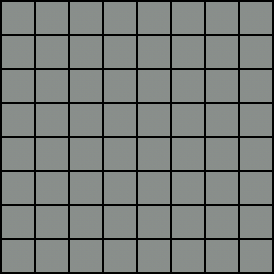

In [65]:
from IPython.display import display, Image
img_path = os.path.join(os.getcwd(), "imgs", "training")
gif_path = os.path.join(img_path, "progress.gif")
display(Image(filename=gif_path))

### Generating some Images

In [80]:
imgs = trainer.generate()
grid1 = torchvision.utils.make_grid(imgs, nrow=8)

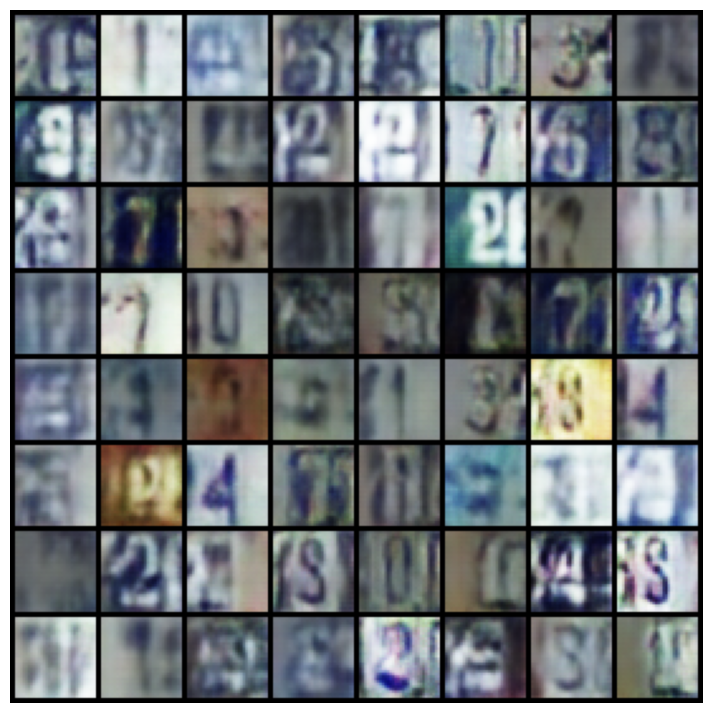

In [81]:
plt.figure(figsize=(9,9))
plt.imshow(grid1.cpu().numpy().transpose(1, 2, 0))
plt.axis("off")
plt.show()

#### Insights:
The results are still pretty blur and can be improved by trying different parameters but these are the most good results i got after trying different parameters changes. I tried to change batch size number of epochs, optimizer and also tried different learning rates.

# Reference:
I used the code from session and then saw youtube videos about how to pass labels to generator and descriminator to make it a conditional gan and then modified session's code and passed labels tensor to model by using Conditional BatchNorm Approach.
https://www.youtube.com/watch?v=W5NPlZzebO0&ab_channel=DigitalSreeni